In [11]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os, io
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils as image
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import models


In [13]:
# Set the path to the dataset directory
dataset_path = 'table_cells'

# Set the desired image size
image_size = (100,50)

# Initialize empty lists to store the images and their corresponding labels
images = []
labels = []

# Loop through each class folder
for class_folder in os.listdir(dataset_path):
    # Construct the full path to the class folder
    class_path = os.path.join(dataset_path, class_folder)
    
    # Check if the item is a directory (i.e., a class folder)
    if os.path.isdir(class_path):
        # Loop through each image file in the class folder
        for filename in os.listdir(class_path):
            # Construct the full path to the image file
            image_path = os.path.join(class_path, filename)
            
            # Load the image using cv2.imread()
            image1 = cv2.imread(image_path)
            
            # Resize the image to the desired size
            image2 = cv2.resize(image1, image_size)
            #image3 = np.reshape(image2, [-1,image_size])
            image3 = image2.astype('float32')
            image3 /= 255
            # Append the image and its corresponding label to the lists
            images.append(image3)
            label = keras.utils.to_categorical(class_folder, num_classes=31)
            #labels.append(numbers_to_strings(class_folder))
            labels.append(label)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Print the shapes of the arrays
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (13402, 50, 100, 3)
y shape: (13402, 31)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


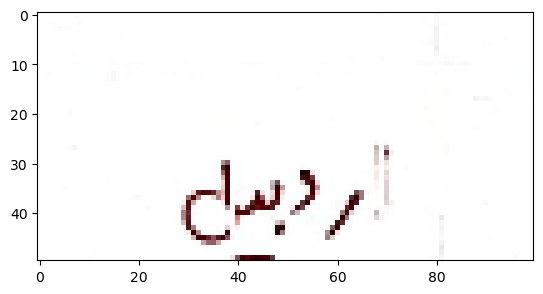

In [14]:
plt.imshow(images[1500])
print(labels[1500])

In [15]:
train_size=0.9
images, labels = np.array(images), np.array(labels)

# 1. Get the total size of the dataset
size = len(images)
# 2. Make an indices array and shuffle it, if required
indices = np.arange(size)
np.random.shuffle(indices)
# 3. Get the size of training samples
train_samples = int(size * train_size)
# 4. Split data into training and validation sets
x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [16]:
def encode_single_sample(img,label):
    
    img = tf.transpose(img, perm=[1, 0, 2])
    return img, label

In [17]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [40]:
test_ds = validation_dataset.shard(num_shards=2, index=0)
validation_dataset = validation_dataset.shard(num_shards=2, index=1)

In [41]:
a, b = next(iter(train_dataset))
print(a.shape)
print(b.shape)

(32, 100, 50, 3)
(32, 31)


In [42]:
from tensorflow.keras.layers import LSTM, TimeDistributed,Bidirectional
from tensorflow.keras import models, layers

model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 50, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

# Calculate the new shape after the convolutional and pooling layers
new_shape = (4, 1, 128)

model_2.add(layers.Reshape(new_shape))

# Add the first RNN layer
model_2.add(TimeDistributed(LSTM(64, return_sequences=True)))

# Add the second RNN layer
model_2.add(TimeDistributed(LSTM(64)))

model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(31, activation='softmax'))

model_2.summary()
model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 98, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 49, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 47, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 23, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 21, 9, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 4, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 4, 1, 64)            │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 4, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 470,751 (1.80 MB)

 Trainable params: 470,751 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
epochs = 30
early_stopping_patience = 10
reduce_lr_patience = 7

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True, mode='max'
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=reduce_lr_patience)

# Train the model
history = model_2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.0959 - loss: 3.1600 - val_accuracy: 0.4439 - val_loss: 1.8778 - learning_rate: 0.0010
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.4222 - loss: 1.8423 - val_accuracy: 0.5785 - val_loss: 1.4183 - learning_rate: 0.0010
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5827 - loss: 1.3937 - val_accuracy: 0.6861 - val_loss: 1.0733 - learning_rate: 0.0010
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.6821 - loss: 1.0762 - val_accuracy: 0.7593 - val_loss: 0.8365 - learning_rate: 0.0010
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.7550 - loss: 0.8499 - val_accuracy: 0.7459 - val_loss: 0.8671 - learning_rate: 0.0010
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8004 - loss: 0.6980 - val_accuracy: 0.8161 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 7/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.8370 - l

In [44]:
model_2.evaluate(validation_dataset)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8943 - loss: 0.5576


[0.6355875730514526, 0.9013453125953674]

Text(0, 0.5, 'Accuracy [%]')

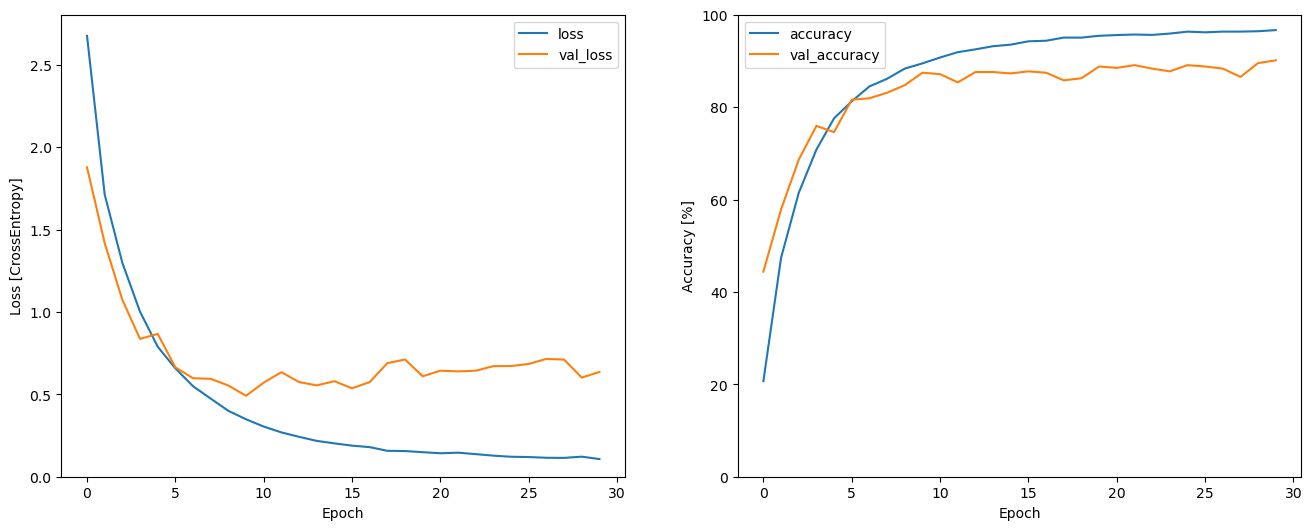

In [45]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [46]:
import numpy as np

# Load the image you want to predict
#image_path = 'table_cells/table_cells_class02/26/rwaw6wDrQi.jpg'
image_path = 'c10.jpg'
image = cv2.imread(image_path)

# Preprocess the image to match the model's input size
image = cv2.resize(image, image_size)
image = image.astype('float32')
image /= 255
image = tf.transpose(image, perm=[1, 0, 2])
# Expand the dimensions to match the model's input shape
image = np.expand_dims(image, axis=0)

# Use the model to predict the class probabilities
predictions = model_2.predict(image)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]

# Print the predicted class label
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
Predicted class: 16


In [75]:

# Save the model
model_2.save('my_model_project4.h5')
print("Model saved to 'my_model_project4.h5'")

Model saved to 'my_model_project4.h5'


In [77]:
#loaded_model = tf.keras.models.load_model('my_model_project4.h5')
import numpy as np
import cv2
# Load the image you want to predict
image_path = 'C:/Users/user/test_for _project/cy.jpg'
image_size = (100,50)
image = cv2.imread(image_path)

# Preprocess the image to match the model's input size
image = cv2.resize(image, image_size)
image = image.astype('float32')
image /= 255
image = tf.transpose(image, perm=[1, 0, 2])
# Expand the dimensions to match the model's input shape
image = np.expand_dims(image, axis=0)

# Use the model to predict the class probabilities
predictions =model_2.predict(image)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]

# Define a mapping between class labels and their names
class_names = ['rasht', 'shiraz', 'shahrkord', 'tabriz', 'khoram-abad', 'qazvin', 'birjand',
              'orumie', 'sari', 'qom', 'mashhad', 'ardebil', 'arak', 'sanandaj',
              'bojnoord', 'esfahan', 'bandar-abbas', 'kerman', 'ahvaz', 'karaj',
              'hamedan', 'kermanshah ', 'zanjan', 'ilam', 'yazd', 'yasooj',
              'semnan', 'booshehr', 'gorgan', 'zahedan', 'tehran']

# Print the predicted class name
print("Predicted class:", class_names[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: yasooj


In [48]:
y_pred = model_2.predict(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [49]:
y_pred = tf.argmax(y_pred, axis=1)

In [50]:
y_true = tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0)

In [69]:
from sklearn.metrics import accuracy_score, classification_report

#prediction=model.predict(x_test)
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)


Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.89      1.00      0.94        25
           2       0.88      0.88      0.88        17
           3       1.00      0.92      0.96        24
           4       0.92      0.81      0.86        27
           5       0.88      0.92      0.90        24
           6       0.81      0.85      0.83        20
           7       0.84      0.94      0.89        17
           8       0.78      0.82      0.80        17
           9       0.90      0.86      0.88        21
          10       0.95      0.95      0.95        19
          11       0.94      0.89      0.92        19
          12       0.88      0.92      0.90        24
          13       0.90      0.79      0.84        24
          14       1.00      0.91      0.95        22
          15       0.95      0.95      0.95        21
          16       1.00      0.84      0.9

In [70]:
from sklearn.metrics import classification_report

# Assuming you have the following variables:
# y_test: true labels
# y_pred: predicted labels

report = classification_report(y_true, y_pred, output_dict=True)

# Get the average precision and recall
avg_precision = report['macro avg']['precision']
avg_recall = report['macro avg']['recall']

print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")


Average Precision: 0.90
Average Recall: 0.90


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<Figure size 1000x800 with 0 Axes>

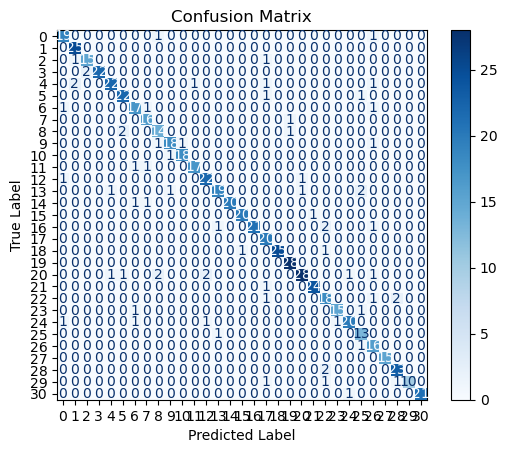

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

y_pred = model_2.predict(test_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.argmax(tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0), axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
confusion_mtx_np = confusion_mtx.numpy()  # Convert TensorFlow tensor to NumPy array

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx_np, display_labels=None)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
